# Credit Scorecard development case study

## Import Dependencies

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None


## Data Loading and Overview

In [42]:
data = pd.read_csv('data/loan_data_2007_2014.csv')

In [43]:
# data.head()
data.sample(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
172609,3144946,3857122,15000,15000,14950.00,36 months,18.49,545.99,D,D2,US Army,10+ years,MORTGAGE,90652.64,Source Verified,Jan-13,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 01/11/13 > I am requesting...,other,Legal Fees,283xx,NC,20.37,0.0,Oct-03,1.0,NaN,NaN,11.0,0.0,19658,64.9,34.0,f,0.00,0.00,4070.24000,4056.70,1956.68,1307.92,0.0,805.64,7.958,Jul-13,545.99,NaN,Dec-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,205276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30300.0,NaN,NaN,NaN
351061,20690917,22963458,25000,25000,25000.00,36 months,13.35,846.57,C,C2,Compliance Associate,10+ years,RENT,85000.00,Verified,Jul-14,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,103xx,NY,3.20,0.0,Jun-94,1.0,NaN,NaN,5.0,0.0,7681,28.7,15.0,w,0.00,0.00,25815.33279,25815.33,25000.00,815.33,0.0,0.00,0.000,Oct-14,24122.19,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,7681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26800.0,NaN,NaN,NaN
104950,6625897,8208059,14875,14875,14825.00,60 months,11.55,327.52,B,B3,Army Benefits Center-Civilian,8 years,MORTGAGE,63500.00,Verified,Aug-13,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Lower Payment Loan,674xx,KS,18.63,0.0,Jun-94,0.0,NaN,NaN,8.0,0.0,4459,59.5,19.0,f,8742.57,8713.18,9497.12000,9465.20,6132.43,3364.69,0.0,0.00,0.000,Jan-16,327.52,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,152633.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7500.0,NaN,NaN,NaN
153133,3916217,5008561,20000,20000,20000.00,36 months,11.14,656.11,B,B2,Texas Instruments,10+ years,OWN,116000.00,Verified,Apr-13,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 03/25/13 > Borrowed for da...,debt_consolidation,Credit Card and Loan Restructure,750xx,TX,22.17,0.0,Sep-82,2.0,NaN,NaN,32.0,0.0,31853,39.6,51.0,f,0.00,0.00,23327.45386,23327.45,20000.00,3327.45,0.0,0.00,0.000,Jun-15,6925.20,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,220605.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80400.0,NaN,NaN,NaN
409107,13526843,15579144,22500,22500,22500.00,36 months,8.90,714.45,A,A5,Plant Manager,10+ years,MORTGAGE,60000.00,Source Verified,Apr-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,907xx,CA,11.68,0.0,Jun-01,0.0,NaN,NaN,10.0,0.0,16980,45.5,18.0,w,10106.65,10106.65,15003.45000,15003.45,12393.35,2610.10,0.0,0.00,0.000,Jan-16,714.45,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,21517.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37300.0,NaN,NaN,NaN
309794,26829598,29312636,18300,18300,18300.00,36 months,7.69,570.85,A,A4,Claims Specialist,10+ years,MORTGAGE,56500.00,Source Verified,Sep-14,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,117xx,NY,15.82,1.0,Apr-00,1.0,2.0,NaN,7.0,0.0,19623,62.7,22.0,w,0.00,0.00,19589.71000,19589.71,18300.00,1289.71,0.0,0.00,0.000,Sep-15,13310.36,NaN,Oct-15,0.0,NaN,1,INDIVIDUAL,NaN,

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [45]:
# Get a list of columns that have more than 80% of the values missing
null_values = data.isnull().mean()
null_values[null_values > 0.8]

mths_since_last_record       0.865666
annual_inc_joint             1.000000
dti_joint                    1.000000
verification_status_joint    1.000000
open_acc_6m                  1.000000
open_il_6m                   1.000000
open_il_12m                  1.000000
open_il_24m                  1.000000
mths_since_rcnt_il           1.000000
total_bal_il                 1.000000
il_util                      1.000000
open_rv_12m                  1.000000
open_rv_24m                  1.000000
max_bal_bc                   1.000000
all_util                     1.000000
inq_fi                       1.000000
total_cu_tl                  1.000000
inq_last_12m                 1.000000
dtype: float64

# Remove Empty Columns

In [46]:
# Drop columns that have more than 80% of the values missing
data.dropna(thresh = data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

In [47]:
# drop redundant and forward-looking columns
# redundant like id, member_id, title, etc.
# forward-looking like recoveries, collection_recovery_fee, etc.
# drop sub_grade as same information is captured in grade column
# drop next_pymnt_d since, given that our data is historical and this column is supposed to have future dates, will not make sense for our model

data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                          'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  loan_status                  466285 non-null  object 
 13 

## Identify the target / dependent variable

In [49]:
# Find the dependent variable - loan_status in this case
data.loan_status.value_counts() 

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [50]:
data.loan_status.value_counts(normalize=True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

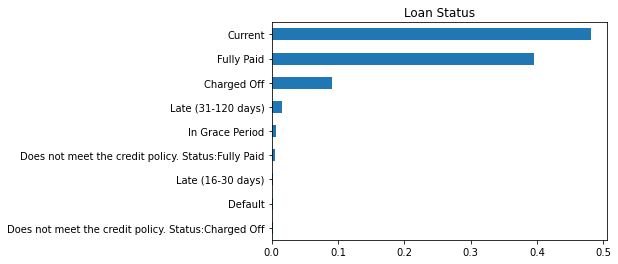

In [51]:
# Plot it as a bar chart
data.loan_status.value_counts(normalize=True).sort_values().plot(kind='barh')
plt.title('Loan Status')
plt.show()

In [52]:
# Create a new column based on loan_status thatt will be our target variable
# 1 - Good Loan (Fully Paid, Current, In Grace Period)
# 0 - Bad Loan (Charged Off, Default, Late (31-120 days), Does not meet the credit policy. Status:Charged Off)
data['good_bad'] = np.where(data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)


# Drop the original 'loan_status' column
data.drop(columns = ['loan_status'], inplace = True)

In [53]:
data['good_bad'].value_counts(normalize=True)

1    0.890693
0    0.109307
Name: good_bad, dtype: float64

## Split the data into train and test

In [78]:
# Split the data into train and test (80-20 split)
# Use random_state = 42 to ensure that the results are reproducible
# Use stratify to ensure that the proportion of good and bad loans is the same in both train and test sets
X = data.drop(columns = 'good_bad')
y = data['good_bad']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train, X_test = X_train.copy(), X_test.copy()

In [79]:
# Check the shape of the train and test sets
X_train.shape, X_test.shape

((373028, 42), (93257, 42))

# Data Cleaning / Preprocessing

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  pymnt_plan                   466285 non-null  object 
 13 

In [81]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,n,credit_card,AZ,27.65,0.0,Jan-85,1.0,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,861.07,Jan-15,171.62,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,n,car,GA,1.00,0.0,Apr-99,5.0,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,435.17,Apr-13,119.66,Sep-13,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,n,small_business,IL,8.72,0.0,Nov-01,2.0,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,603.65,Jun-14,649.91,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,n,other,CA,20.00,0.0,Feb-96,1.0,35.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,2209.33,Jan-15,357.48,Jan-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
4,3000,3000,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Dec-11,n,other,OR,17.94,0.0,Jan-96,0.0,38.0,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,1009.07,Jan-16,67.79,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1


In [82]:
# emp_length

def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

# Apply to X_train
emp_length_converter(X_train, 'emp_length')

# X_train['emp_length'].value_counts()
X_train['emp_length'].unique()

'''
# Is this wise to do? 
# We have variables like: < 1 year and 10+ years which are ordinal in nature
# We are converting them to numeric variables which are not ordinal in nature
# We are assuming that 10+ years is greater than 1 year which is not true

# We can use One-Hot Encoding to convert these variables to numeric variables
# We can also use Ordinal Encoding to convert these variables to ordinal variables

# We will use Ordinal Encoding here
# We will create a dictionary that will map the values to the respective numbers
# We will then use the map function to map the values to the respective numbers

# Create a dictionary
emp_length_dict = {k: v for v, k in enumerate(sorted(X_train['emp_length'].unique()))}

# Map it to the emp_length column
X_train['emp_length'] = X_train['emp_length'].map(emp_length_dict)
'''

"\n# Is this wise to do? \n# We have variables like: < 1 year and 10+ years which are ordinal in nature\n# We are converting them to numeric variables which are not ordinal in nature\n# We are assuming that 10+ years is greater than 1 year which is not true\n\n# We can use One-Hot Encoding to convert these variables to numeric variables\n# We can also use Ordinal Encoding to convert these variables to ordinal variables\n\n# We will use Ordinal Encoding here\n# We will create a dictionary that will map the values to the respective numbers\n# We will then use the map function to map the values to the respective numbers\n\n# Create a dictionary\nemp_length_dict = {k: v for v, k in enumerate(sorted(X_train['emp_length'].unique()))}\n\n# Map it to the emp_length column\nX_train['emp_length'] = X_train['emp_length'].map(emp_length_dict)\n"

In [83]:
# Convert date columns to datetime format
# And create a new column as a difference between today and the respective date column

def date_converter(df, column):
    # store current month
    today_date = pd.to_datetime('2023-05-14')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# apply to X_train
date_converter(X_train, 'earliest_cr_line')
date_converter(X_train, 'issue_d')
date_converter(X_train, 'last_pymnt_d')
date_converter(X_train, 'last_credit_pull_d')

# let's check these new columns
print(X_train['mths_since_earliest_cr_line'].describe())
print(X_train['mths_since_issue_d'].describe())
print(X_train['mths_since_last_pymnt_d'].describe())
print(X_train['mths_since_last_credit_pull_d'].describe())

count    373003.000000
mean        307.293609
std          86.372742
min         138.000000
25%         248.000000
50%         290.000000
75%         350.000000
max         652.000000
Name: mths_since_earliest_cr_line, dtype: float64
count    373028.000000
mean        116.252485
std          14.339074
min         101.000000
25%         106.000000
50%         112.000000
75%         122.000000
max         191.000000
Name: mths_since_issue_d, dtype: float64
count    372717.000000
mean         96.289989
std          12.803859
min          88.000000
25%          88.000000
50%          89.000000
75%         100.000000
max         185.000000
Name: mths_since_last_pymnt_d, dtype: float64
count    372998.000000
mean         92.041810
std           9.630887
min          88.000000
25%          88.000000
50%          88.000000
75%          90.000000
max         192.000000
Name: mths_since_last_credit_pull_d, dtype: float64


In [84]:
# term column = 36 months, 60 months
# X_train['term'].value_counts()
# remove ' months' from the values and convert to numeric
X_train['term'] = X_train['term'].str.replace(' months', '').astype(int)

In [85]:
X_train.sample(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
218761,35000,35000,35000.0,60,20.99,946.68,E,0.0,MORTGAGE,120000.0,Verified,n,debt_consolidation,AK,14.65,0.0,2.0,NaN,10.0,0.0,33336,70.2,23.0,f,0.00,0.00,47387.75585,47387.76,12387.76,26586.21,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,478.0,132.0,109.0,109.0
348156,4700,4700,4700.0,36,12.49,157.21,B,2.0,RENT,29120.0,Not Verified,n,credit_card,MN,30.41,1.0,0.0,16.0,10.0,0.0,7787,38.9,17.0,f,2568.36,2568.36,2829.78000,2829.78,698.14,157.21,0.0,NaN,1,INDIVIDUAL,0.0,0.0,31621.0,20000.0,216.0,106.0,88.0,88.0
225151,15000,15000,15000.0,36,13.99,512.60,C,6.0,RENT,118000.0,Not Verified,n,credit_card,MD,11.76,0.0,2.0,69.0,10.0,0.0,15603,30.7,16.0,f,0.00,0.00,18188.79388,18188.79,3188.79,4887.87,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,367.0,134.0,107.0,107.0
118215,18150,18150,18150.0,60,21.60,497.17,E,10.0,MORTGAGE,55169.0,Verified,n,credit_card,TN,29.28,0.0,1.0,NaN,10.0,0.0,27304,73.0,31.0,w,11446.88,11446.88,14915.10000,14915.10,8211.98,497.17,0.0,NaN,1,INDIVIDUAL,0.0,0.0,57045.0,37400.0,322.0,118.0,88.0,88.0
374735,24000,24000,24000.0,36,8.39,756.40,A,2.0,RENT,100000.0,Source Verified,n,debt_consolidation,CA,10.20,0.0,0.0,NaN,7.0,0.0,43895,84.4,27.0,w,0.00,0.00,25931.54000,25931.54,1931.54,1572.74,0.0,NaN,1,INDIVIDUAL,0.0,0.0,296270.0,52000.0,319.0,107.0,89.0,89.0


In [86]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      373028 non-null  int64  
 1   funded_amnt                    373028 non-null  int64  
 2   funded_amnt_inv                373028 non-null  float64
 3   term                           373028 non-null  int64  
 4   int_rate                       373028 non-null  float64
 5   installment                    373028 non-null  float64
 6   grade                          373028 non-null  object 
 7   emp_length                     373028 non-null  float64
 8   home_ownership                 373028 non-null  object 
 9   annual_inc                     373024 non-null  float64
 10  verification_status            373028 non-null  object 
 11  pymnt_plan                     373028 non-null  object 
 12  purpose                   

# Feature Selection

In [87]:
# First divide training data into categorical and numerical subsets
X_train_num = X_train.select_dtypes(include = np.number).copy()
X_train_cat = X_train.select_dtypes(include = np.object).copy()

## Chi-squared statistic for categorical variables

In [88]:
# initialize an empty dictionary to store the results of chi-square test
chi_sq_results = {}

# loop over all the categorical variables
for col in X_train_cat.columns:
    chi, pi, dof, expected = chi2_contingency(pd.crosstab(y_train, X_train_cat[col]))

    chi_sq_results.setdefault('Feature', []).append(col)
    chi_sq_results.setdefault('p-value', []).append(round(pi, 10))


# convert the dictionary to a dataframe
chi_sq_results = pd.DataFrame(chi_sq_results)

# sort the dataframe by p_value
chi_sq_results.sort_values(by = 'p-value', ascending = True, ignore_index=True, inplace = True)

chi_sq_results


,Feature,p-value
0,grade,0.000000
1,home_ownership,0.000000
2,verification_status,0.000000
3,purpose,0.000000
4,addr_state,0.000000
5,initial_list_status,0.000000
6,pymnt_plan,0.000923
7,application_type,1.000000


We will use the chi-squared statistic to identify the categorical variables that are most predictive of the target variable. We will select the top 4 variables.
Those columns are: 'application_type', 'pymnt_plan', 'addr_state', 'home_ownership'

## ANOVA F-Statistic for numerical variables

In [89]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      373028 non-null  int64  
 1   funded_amnt                    373028 non-null  int64  
 2   funded_amnt_inv                373028 non-null  float64
 3   term                           373028 non-null  int64  
 4   int_rate                       373028 non-null  float64
 5   installment                    373028 non-null  float64
 6   emp_length                     373028 non-null  float64
 7   annual_inc                     373024 non-null  float64
 8   dti                            373028 non-null  float64
 9   delinq_2yrs                    373003 non-null  float64
 10  inq_last_6mths                 373003 non-null  float64
 11  mths_since_last_delinq         172651 non-null  float64
 12  open_acc                  

In [90]:
# Since f_class_if does not accept missing values, wee will do a avery crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)

# Calculate the F Statistic and corresponding p value
f_stat, p_value = f_classif(X_train_num, y_train)

# Create a dataframe to store the results
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': f_stat, 'p values': p_value.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,mths_since_last_pymnt_d,23513.805570,0.000000e+00
1,total_pymnt_inv,14784.534040,0.000000e+00
2,total_pymnt,14686.729567,0.000000e+00
3,int_rate,11462.788313,0.000000e+00
4,last_pymnt_amnt,10826.949727,0.000000e+00
5,out_prncp,9635.116160,0.000000e+00
6,out_prncp_inv,9633.442129,0.000000e+00
7,mths_since_last_credit_pull_d,7020.218888,0.000000e+00
8,mths_since_issue_d,2816.028871,0.000000e+00
9,inq_last_6mths,2003.820465,0.000000e+00


In [91]:
X_train_num.policy_code.value_counts()

1    373028
Name: policy_code, dtype: int64

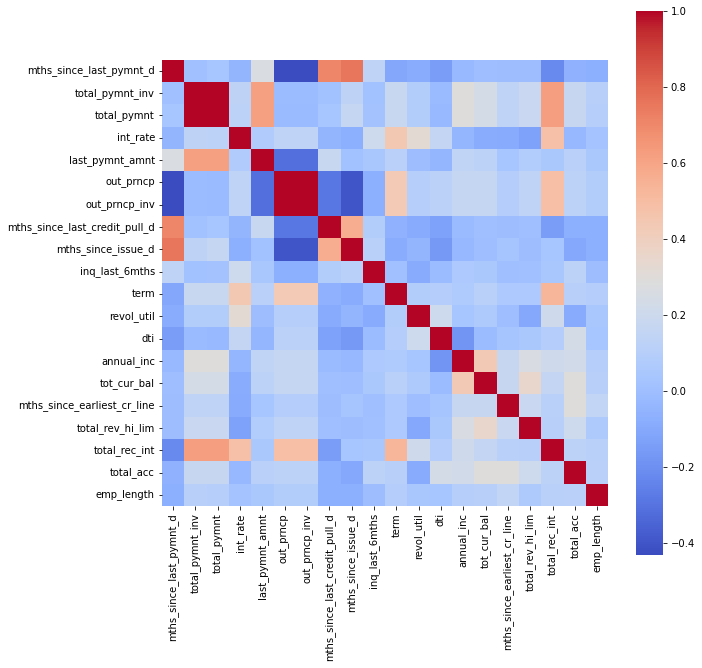

In [92]:
# Keep the top 20 numerical features
top_num_features = ANOVA_F_table.iloc[:20, 0].tolist()
# Calculate the pair-wise correlations between the variables
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corrmat, annot = False, square = True, cmap = 'coolwarm');


# # Do it again for all the features
# corrmat = X_train_num.corr()
# plt.figure(figsize = (10, 10))
# sns.heatmap(corrmat, annot = False, square = True, cmap = 'coolwarm');



The ANOVA F-Statistic is used to identify the numerical variables that are most predictive of the target variable. We will select the top 4 variables. Those columns are: 'total_rec_late_fee', 'total_rec_int', 'total_rec_prncp', 'recoveries'

In [93]:
# Define a helper function to drop the 4 categorical features with least p-values for chi squared test, 14 numerical features with least F-Statistic
# and 2 numerical features with high multicollinearity
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi_sq_results.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)

# Create Dummy Variables

In [94]:
# Convert the categorical variables to dummy variables
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   term                           373028 non-null  int64  
 1   int_rate                       373028 non-null  float64
 2   grade                          373028 non-null  object 
 3   emp_length                     373028 non-null  float64
 4   home_ownership                 373028 non-null  object 
 5   annual_inc                     373024 non-null  float64
 6   verification_status            373028 non-null  object 
 7   purpose                        373028 non-null  object 
 8   dti                            373028 non-null  float64
 9   inq_last_6mths                 373003 non-null  float64
 10  revol_util                     372764 non-null  float64
 11  total_acc                      373003 non-null  float64
 12  out_prncp                 

In [97]:
def create_dummy(df, column_list):
    '''
    This function will create dummy variables for the categorical variables

    df: the dataframe
    column_list: list of categorical columns
    '''
    df_dummies = []
    for col in column_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to X_train
X_train = create_dummy(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])



In [99]:
X_train.sample(5)

,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,revol_util,total_acc,out_prncp,total_pymnt,total_rec_int,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding
426878,60,15.61,C,10.0,MORTGAGE,70000.0,Source Verified,debt_consolidation,15.70,1.0,57.2,23.0,0.00,24003.22,4003.22,16287.54,188036.0,23700.0,301.0,110.0,93.0,88.0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
424298,36,11.99,B,0.0,RENT,53400.0,Source Verified,credit_card,9.73,0.0,57.4,7.0,0.00,4454.47,884.57,282.29,15926.0,6200.0,172.0,110.0,98.0,93.0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
270820,36,13.35,C,10.0,OWN,60099.0,Source Verified,debt_consolidation,30.21,1.0,62.4,42.0,9863.81,7100.18,1963.99,507.95,129281.0,12900.0,448.0,103.0,89.0,88.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
29662,60,10.99,B,4.0,MORTGAGE,70000.0,Not Verified,debt_consolidation,21.33,3.0,33.0,25.0,0.00,10938.92,2113.88,4623.10,NaN,NaN,307.0,155.0,121.0,88.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
246290,60,24.99,F,9.0,RENT,49000.0,Source Verified,debt_consolidation,24.86,0.0,56.7,18.0,17966.44,7782.59,5199.03,603.05,42041.0,12800.0,194.0,102.0,89.0,88.0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


# Update the Test set

In [111]:
# Update the Test set
emp_length_converter(X_test, 'emp_length')
date_converter(X_test, 'earliest_cr_line')
date_converter(X_test, 'issue_d')
date_converter(X_test, 'last_pymnt_d')
date_converter(X_test, 'last_credit_pull_d')
X_test['term'] = X_test['term'].str.replace(' months', '').astype(int)
col_to_drop(X_test, drop_columns_list)
X_test = create_dummy(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])
# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

# Weight of Evidence (WoE) - Binning / Feature Engineering

- We will analyze both categorical and numerical features on their categorical/binned WoEs and IVs (Information Value) and then combine some of these binned categories together through a custom Python Class with fit_transform method.

In [112]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

## Analyze WoEs and IVs of discrete features